코드 생성

In [761]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [762]:
OV = 4
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000

# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4?
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [763]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.000001

# 잡음의 크기 설정
num_samples = 1023 *20 * (ms//20) * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 
imaginary_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [764]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)



Signal 생성

In [765]:
class trans_signal:
    def __init__(self, code_delay, doppler_freq, svNumber, code_freq, bits, OV):
        self.delay = code_delay
        self.doppler = doppler_freq
        self.svNumber = svNumber
        
        self.seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
        t = np.arange(1023 * OV * 20 * bits)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def signal(self):
        return self.seq * self.oversampled_signal + complex_noise       

Replica 신호 생성

In [766]:
class Replica:
    def __init__(self, code_delay, doppler_freq, code_freq, svNumber, signal_length, OV, ts, tvar):
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip in ca_code for _ in range(OV)]
        complement = 1023 * OV - tvar
        temp1 = np.arange(1023 * OV * ts + tvar, 1023 * OV * ts + tvar + complement)
        temp2 = np.arange((1023 * OV * ts + tvar + complement) % (1023*OV*ms), (1023 * OV * ts + tvar + 1023* OV) % (1023*OV*ms))
        t = np.concatenate((temp1, temp2))

        self.delayed_code = np.roll(ca_code, code_delay)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal

Acquisition

In [767]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, OV):
    
    # 신호 1ms씩 쪼개기
    sig = signal.signal()
    signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    dop_freq_max = []
    Fsignal = signal_div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = Replica(code_delay_range[0], doppler_freq, code_freq, svNumber, 1023 * OV, OV, 0, 0)
        dop= []
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica.signal(), mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            dop.append(peak)
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            #replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            replica.delay(OV if OV == 1 else OV//2)
            
        dop_freq_max.append(max(dop))
        
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    complement = 1023*OV - max_code_delay
    # signal_div = [sig[(i+max_code_delay)%(1023*OV*ms):(i+(1023*OV)+max_code_delay)%(1023*OV*ms)] for i in range(0,len(sig)+1, 1023*OV)]
    signal_div = []
    for i in range(0, len(sig), 1023 * OV):
        temp1 = sig[i+max_code_delay:i+max_code_delay + complement]
        temp2 = sig[(i+max_code_delay + complement) % (1023*OV*ms) : (i+max_code_delay + 1023*OV) % (1023*OV*ms)]
        signal_div.append(np.concatenate((temp1, temp2))) 

    cor_lst = []
    for i in range(ms):
        True_replica = Replica(0, max_doppler_freq, code_freq, svNumber, 1023 * OV, OV, i, max_code_delay)
        #print(True_replica)
        #print(signal_div[i])
        cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
        cor_lst.append(np.max(cor))  
    return max_code_delay, max_doppler_freq, cor_lst, corr_matrix, dop_freq_max
    

Acquisition 실행

In [768]:
code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20* 1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)
true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = 520

received_signal = trans_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, ms//20, OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, cor_lst, corr_matrix, dop_max= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 
B = true_code_delay//(OV*1023)
print("B :", B)
print()
for i in range(-10,11):
    print(f"{i*500}Hz : {dop_max[i+10]}")


----------------------------------------
Frame Sync completed.
Frame delay : 502.0
Estimated_Frequency Offset : 4000.0
Max correlation : 766.8438078014556
----------------------------------------

------------------ Test ------------------
Target SV Number: 16
True Code Delay: 9709.0
True doppler frequency: 4138
----------------------------------------
B : 9

-5000Hz : 109.38430610695424
-4500Hz : 102.83139381138243
-4000Hz : 113.09581796905157
-3500Hz : 110.20117438910674
-3000Hz : 107.3572078979556
-2500Hz : 108.62206159828574
-2000Hz : 103.68859680359424
-1500Hz : 113.67570701594227
-1000Hz : 98.14075236597371
-500Hz : 115.85040477094911
0Hz : 113.29138219768492
500Hz : 103.15203774819217
1000Hz : 111.39285178955774
1500Hz : 103.41013860684728
2000Hz : 101.85011013888709
2500Hz : 164.42350579065274
3000Hz : 136.01369540208213
3500Hz : 338.2375482723266
4000Hz : 766.8438078014556
4500Hz : 636.8909892646499
5000Hz : 116.75231732002754


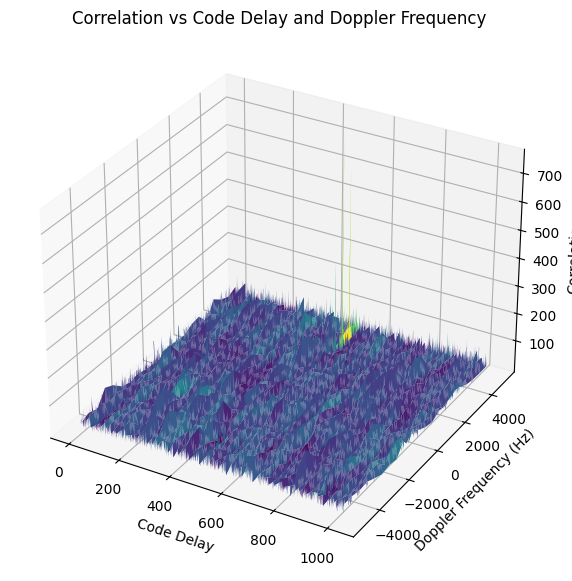

In [769]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



In [770]:
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 

degree_list = [np.degrees(value) for value in phase_diff]

Index 0: -44.8703937318922
Index 1: -53.01533357785083
Index 2: -47.58968098090989
Index 3: -49.8546674453918
Index 4: -54.15629473593234
Index 5: -47.088533491720824
Index 6: -48.606733247959134
Index 7: -50.54626304312492
Index 8: -49.29881186840156
Index 9: -50.117957351760175
Index 10: -52.46026968589997
Index 11: -48.54365515593365
Index 12: -47.78313520669989
Index 13: -53.36066286115353
Index 14: -45.91358687589942
Index 15: -48.36208771863002
Index 16: -50.672569333991675
Index 17: -48.92967580092812
Index 18: -52.13122043587314
Index 19: -48.43962083131696
Index 20: -49.55406807452326
Index 21: -50.73562039974117
Index 22: -47.317314850584836
Index 23: -51.64840569229048
Index 24: -48.07963002041427
Index 25: -52.925910558591816
Index 26: -48.52882978410034
Index 27: -48.26859757118324
Index 28: 129.23170417695994
Index 29: -47.69077611963722
Index 30: -50.32076593730916
Index 31: -49.26803771529175
Index 32: -48.85885934271634
Index 33: -52.727095790080895
Index 34: -49.05381

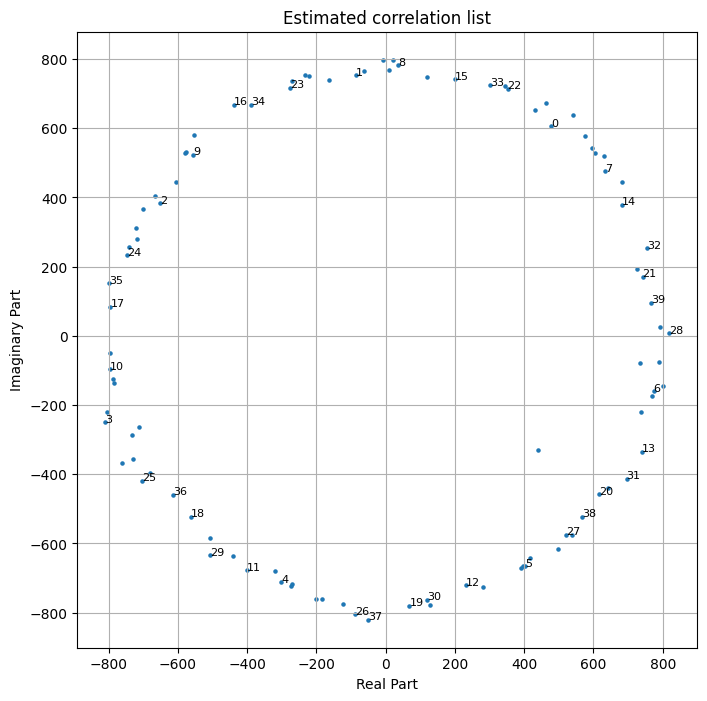

In [771]:

for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")



plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(0, 0 + 40)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

In [772]:
def find_outliers(data):
    outliers = []
    threshold = 1.5 # 일반적으로는 1.5를 사용합니다.

    data_sorted = sorted(data)
    q1, q3 = np.percentile(data_sorted, [15, 85])
    iqr = q3 - q1

    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    for i, x in enumerate(data):
        if x < lower_bound or x > upper_bound:
            outliers.append(x)

    return outliers


# data = degree_list

outliers = find_outliers(degree_list)
print("이상치:", outliers)

outlier_index = 0
if len(outliers)>=1:
    tmp = outliers[1]
    print("첫번째 이상치", tmp)
    idx = degree_list.index(tmp)

    outlier_index = idx
    print("원래", outlier_index)

    if outlier_index>=20:
        outlier_index = outlier_index % 20
        
    print("estimated B", outlier_index)
    print("B", B)
elif len(outliers) == 0:
    print("B = 0")
    
print()

def find_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = [(i + 20, x) for i, x in enumerate(data) if abs((x - mean) / std) > threshold]
    return outliers

dl = degree_list[20:40]
outliers_z = find_outliers_z_score(dl)
print("참고: 이상치 (Z-Score):", outliers_z)

이상치: [129.23170417695994, 124.98551601912833, 133.5399674156409, 130.60347806580975, -88.02942125528844]
첫번째 이상치 124.98551601912833
원래 48
estimated B 8
B 9

참고: 이상치 (Z-Score): [(28, 129.23170417695994)]


In [773]:
# degree_list = degree_list[outlier_index:] + degree_list[:outlier_index]
degree_list = np.roll(degree_list, -outlier_index)
cor_lst = np.roll(cor_lst, -outlier_index)
"""
# Added
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 

degree_list = [np.degrees(value) for value in phase_diff]
"""
phase_diff = np.roll(phase_diff,-outlier_index)

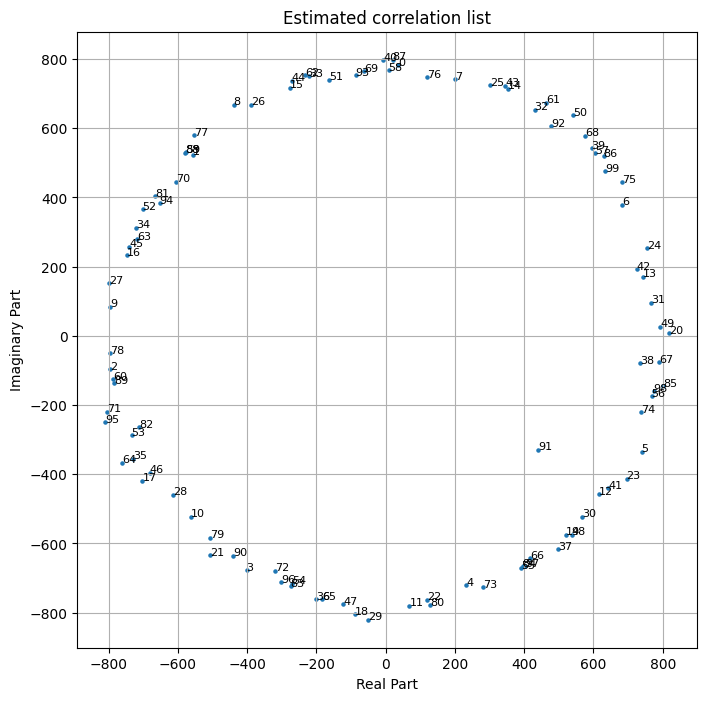

In [774]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(0, 0 + 100)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

In [775]:
mean_diff_p = []
for i in range(ms//20):
    mean = np.average(phase_diff[i*20 + 2: i*20 + 19])
    print(mean)
    mean_diff_p.append(mean)

mean_diff = [np.average(mean_diff_p)] * (ms//20)

-0.8679278673813148
-0.8659357876288103
-0.8649401662252039
-0.8642175086719472
-0.9020928321704695


1 bit change
2 bit change
3 bit change
4 bit change
[1, -1, 1, -1, 1]


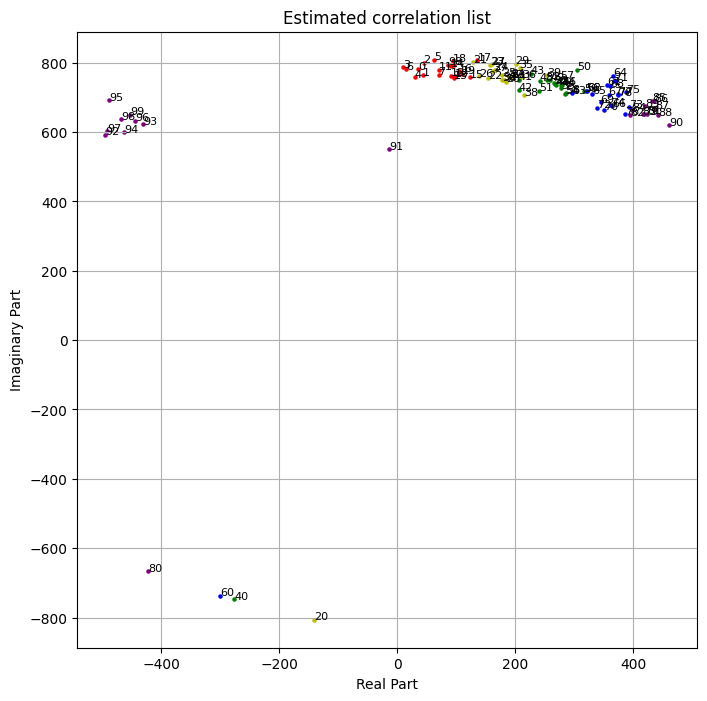

In [776]:

import cmath
# cumulative_phase = 0
new_result = []
cur_no = 0
phase_change = 0
for i in range(ms//20):
    new = [0] * 20
    if i == 0:
        cur_no += 1
        new[0] = cor_lst[0]
        for j in range(len(cor_lst[1:20])):
            current_phase = mean_diff[i] * cur_no
            new[j+1] = cor_lst[j+1] * np.exp(1j * current_phase)
            cur_no += 1
    elif i != 0:
        if abs((degree_list[(20 * i) - 1])-(degree_list[20*i])) > 45:
            phase_change += 1
            print(i, "bit change")
        for j in range(20):
            current_phase = mean_diff[i] * cur_no + np.pi * phase_change
            new[j] = cor_lst[20 * i + j] * np.exp(1j * current_phase)
            cur_no += 1
    new_result += new
    
plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_result[:20]), np.imag(new_result[:20]), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_result[20:40]), np.imag(new_result[20:40]), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_result[40:60]), np.imag(new_result[40:60]), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_result[60:80]), np.imag(new_result[60:80]), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_result[80:100]), np.imag(new_result[80:100]), s=5, label='New_s_5', c='purple')


print(data)
for i, txt in enumerate(range(0, 100)):
    plt.annotate(f'{txt}', (np.real(new_result[i]), np.imag(new_result[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
#m = max(np.real(new_result[:]))
#plt.xlim(-1.1*m, 1.1*m)
#plt.ylim(-1.1*m, 1.1*m)
plt.grid(True)
plt.show()

In [777]:
for i, p in enumerate(degree_list):
    print(i, p)

0 -49.29881186840156
1 -50.117957351760175
2 -52.46026968589997
3 -48.54365515593365
4 -47.78313520669989
5 -53.36066286115353
6 -45.91358687589942
7 -48.36208771863002
8 -50.672569333991675
9 -48.92967580092812
10 -52.13122043587314
11 -48.43962083131696
12 -49.55406807452326
13 -50.73562039974117
14 -47.317314850584836
15 -51.64840569229048
16 -48.07963002041427
17 -52.925910558591816
18 -48.52882978410034
19 -48.26859757118324
20 129.23170417695994
21 -47.69077611963722
22 -50.32076593730916
23 -49.26803771529175
24 -48.85885934271634
25 -52.727095790080895
26 -49.05381300339647
27 -47.52863168012259
28 -49.74609596633817
29 -50.80484761532711
30 -49.870600428682664
31 -49.523529370090586
32 -49.75661390024959
33 -50.07830083143025
34 -49.42046421372937
35 -49.244656485553186
36 -53.785089057180826
37 -44.92567945571432
38 -48.5328405347358
39 -48.09275314943789
40 124.98551601912833
41 -49.39576462836226
42 -49.58678474415913
43 -45.67860312096709
44 -50.648179021117286
45 -49.3158